In [234]:
%load_ext autoreload
%autoreload 2

from sklearn.feature_extraction.text import CountVectorizer
from FeatureEngine.FeatureMethods import FeatureEngine, fuzzy_merge, Supervised_Analyzer, GenerateCramersVMatrix
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA



print(Path.cwd())

pathBase = str(Path.cwd())
cv = CountVectorizer()

df = pd.read_csv(pathBase + "\Datasets\TeraSample_Supervised_MM.csv")

dfValidate = pd.read_csv(pathBase + "\Datasets\HCP_TrainNew.csv")
df_test = pd.read_csv(pathBase + "\Datasets\HCP_TestNew.csv")
#dfOP = pd.read_csv(pathBase + "\Datasets\OpenPmntsVendors.csv")


with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df.astype('object').describe().transpose())
    print(df_test.astype('object').describe().transpose())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
c:\Users\dylan.levine\Development\HCP Classification\HCP-Classification
                                  count   unique  \
HCPClass                         127469        2   
AC_DOC_LN                        127469      234   
AC_DOC_NR                        127469    68571   
AC_DOC_TYP                       127469        6   
AC_DOC_TYP_T                     127469        6   
ACCNT_GRPV                       127469        4   
AP Clearing Date                 127469      568   
AP Clearing Doc No.              127469    11918   
Audit                            127469        7   
BIC_ZHIERLV3                     127469       21   
COMP_CODE                        127469       13   
COMP_CODE_T                      127469       13   
Compliance_Bucket                  5313       14   
DOC_CURRCY                       127469       12   
DOC_DATE                         127469      853   
Expense 

In [235]:
#Define DateEncode as basic features such as day of week, month int, and year int.
#Define groupencode as placing into buckets
#Define mapencode as mapping values to a higher-level grouping

#Define relavent fields to model and their associated data types and feature engineering methods

colDict = {
    "COMP_CODE": {"Type":"Categorical", "Method":"1hot"}, #In
    #"REF_KEY1":{"Type":"Categorical", "Method":"1hot"},
    "AC_DOC_NR": {"Type":"ID", "Method":"N/A"},
    "PSTNG_DATE":{"Type":"Date", "Method":"DateEncode"},
    #"CREATEDON":{"Type":"Date", "Method":"DateEncode"},
    "DOC_DATE":{"Type":"Date", "Method":"DateEncode"},
    "PROFIT_CTR":{"Type":"Categorical", "Method":"1hot"},
    "AC_DOC_TYP":{"Type":"Categorical", "Method":"1hot"},
    "POST_KEY":{"Type":"Categorical", "Method":"1hot"},
    "V.VENDOR":{"Type":"Categorical", "Method":"MapEncode"},#Was creditor
    "V.NAME":{"Type":"Text", "Method":"Tokenize"}, #Was name
    "GL_ACCOUNT":{"Type":"Categorical", "Method":"1hot"},
    #"CUSTOMER":{"Type":"Categorical", "Method":"MapEncode"}, no longer included
    "POSTXT":{"Type":"Text", "Method":"Tokenize"},
    #"BIC_ZUSERNAM":{"Type":"Categorical", "Method":"MapEncode"}, no longer included
    "ZBKTXT":{"Type":"Text", "Method":"Tokenize"},
    "ZTCODE":{"TYpe":"Categorical", "Method":"1hot"},
    "DEB_CRE_USD":{"Type":"Numerical", "Method":"GroupEncode"},
    "V.BIC_ZTERMPAY":{"Type":"Categorical", "Method":"1hot"},
    "MATL_GROUP":{"Type":"Categorical", "Method":"1hot"},
    "ACCNT_GRPV":{"Type":"Categorical", "Method":"1hot"},
    "HCPClass":{"Type":"Categorical", "Method":"LabelEncode"}, #Target
    "Compliance_Bucket":{"Type":"Categorical", "Method":"1hot"},
    "V.BI_ACCNT_TGRPV":{"Type":"Categorical", "Method":"1hot"} #Vendor type
}

oneHotFeatures = ["PROFIT_CTR","AC_DOC_TYP","POST_KEY","GL_ACCOUNT","ZTCODE", "MATL_GROUP", "ACCNT_GRPV","V.BI_ACCNT_TGRPV", "V.BIC_ZTERMPAY"]


#Set pandas datatypes for each field
df['COMP_CODE'] = df['COMP_CODE'].astype('object')
#df['REF_KEY1'] = df['REF_KEY1'].astype('object')
df['AC_DOC_NR'] = df['AC_DOC_NR'].astype('str')
df['PSTNG_DATE'] = pd.to_datetime(df['PSTNG_DATE'], format="%Y%m%d")
#df['CREATEDON'] = pd.to_datetime(df['CREATEDON'].astype('object'), format="%Y%m%d")
df['DOC_DATE'] = pd.to_datetime(df['DOC_DATE'], format="%Y%m%d")
df['PROFIT_CTR'] = df['PROFIT_CTR'].astype('str')
df['AC_DOC_TYP'] = df['AC_DOC_TYP'].astype('object')
df['POST_KEY'] = df['POST_KEY'].astype('str')
#df_test['POST_KEY'] = df_test['POST_KEY'].astype('int')
df['V.VENDOR'] = df['V.VENDOR'].astype('object') #was CREDITOR
df['V.NAME'] = df['V.NAME'].astype('object') #Was #name
df['GL_ACCOUNT'] = df['GL_ACCOUNT'].astype('int')
#df_test['GL_ACCOUNT'] = df_test['GL_ACCOUNT'].astype('object')
#df['CUSTOMER'] = df['CUSTOMER'].astype('object') no longer included
df['POSTXT'] = df['POSTXT'].astype('object')
#df['BIC_ZUSERNAM'] = df['BIC_ZUSERNAM'].astype('object') no longer included, but may be useful to bring back
df['ZBKTXT'] = df['ZBKTXT'].astype('object')
df['ZTCODE'] = df['ZTCODE'].astype('str')
df['DEB_CRE_USD'] = pd.to_numeric(df['DEB_CRE_USD'])
df['V.BIC_ZTERMPAY'] = df['V.BIC_ZTERMPAY'].astype('str') #no longer included, but may be useful to bring back
df['MATL_GROUP'] = df['MATL_GROUP'].astype('str')
df['ACCNT_GRPV'] = df['ACCNT_GRPV'].astype('str')
df['HCPClass'] = df['HCPClass'].astype('object')
df['Compliance_Bucket'] = df['Compliance_Bucket'].astype("object")
df['V.BI_ACCNT_TGRPV'] = df['V.BI_ACCNT_TGRPV'].astype("str")




#Filter data for relavent rows
df = df[ ((df.POST_KEY == '40') | (df.POST_KEY == '81')) & (df.GL_ACCOUNT >= 40000000)]

df['GL_ACCOUNT'] = df['GL_ACCOUNT'].astype('str')
#Filter data for relavent rows
#df_test = df_test[ ((df_test.POST_KEY == 40) | (df_test.POST_KEY == 81)) & (df_test.GL_ACCOUNT >= 40000000)]

#Get list of relavent fields
colSelect = list(colDict.keys())
colSelect = ['COMP_CODE', 'AC_DOC_NR', 'PSTNG_DATE', 'DOC_DATE', 'PROFIT_CTR', 'AC_DOC_TYP', 'POST_KEY', 'V.VENDOR', 'V.NAME', 'GL_ACCOUNT', 'POSTXT', 'ZBKTXT' ,'ZTCODE', 'V.BIC_ZTERMPAY', 'MATL_GROUP', 'ACCNT_GRPV', 'V.BI_ACCNT_TGRPV', 'HCPClass', 'Compliance_Bucket', 'DEB_CRE_USD']


#df[colSelect]
df = df[colSelect]

#df_test[colSelect]


df
#df

,COMP_CODE,AC_DOC_NR,PSTNG_DATE,DOC_DATE,PROFIT_CTR,AC_DOC_TYP,POST_KEY,V.VENDOR,V.NAME,GL_ACCOUNT,POSTXT,ZBKTXT,ZTCODE,V.BIC_ZTERMPAY,MATL_GROUP,ACCNT_GRPV,V.BI_ACCNT_TGRPV,HCPClass,Compliance_Bucket,DEB_CRE_USD
1,1106,2100005016,2019-10-18,2019-09-02,12622,CT,40,50006732,Dr. Alexander Seibold,61000108,GASOLINE,19-Aug,nan,1,nan,Z010,Employee Vendor,Non-HCP,NaN,98.570010
2,1106,2100000555,2020-02-03,2020-01-07,12110,CT,40,50005346,DR. SIMONE BRAUN,61000111,HOTEL ROOM,KW 2&3 2020 ZH,nan,13,nan,Z010,Employee Vendor,Non-HCP,NaN,226.858471
3,1106,2100002293,2019-05-08,2019-04-18,12110,CT,40,50005346,DR. SIMONE BRAUN,61000121,PARKING,"KW 15,16 2019 UL,S",nan,13,nan,Z010,Employee Vendor,Non-HCP,Sponsorship & Hospitality,3.747408
5,1106,2100001411,2020-03-31,2020-01-21,12529,CT,40,50006541,Dr. Bettina Trinschek,61000112,FIXED MEALS (GROSS),RK,nan,1,nan,Z010,Employee Vendor,Non-HCP,NaN,15.370600
6,1106,2100003583,2020-10-14,2020-09-21,12529,CT,40,50006541,Dr. Bettina Trinschek,61000101,PARKING,RK SEPTEMBER,nan,1,nan,Z010,Employee Vendor,Non-HCP,Sponsorship & Hospitality,5.863500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126273,1000,1900121941,2020-09-11,2020-09-11,12935,KR,40,10186420,SIMON TRANSPORT LLC,64900101,0065267231SIMN SIMON TRANS...,LEAN 62130111,BD87,24,nan,Z001,Vendor (Legal Entity),Non-HCP,NaN,1906.280000
126466,1106,5100013643,2020-05-20,2020-01-23,12157,RE,40,10160187,GERHARD MUELLER TRANSPORTE,51000111,4700667749,NaN,MIRO,19,nan,Z001,Vendor (Legal Entity),Non-HCP,N/A-Intercompany,0.000000
126638,1106,5100035908,2020-12-29,2020-09-29,12271,RE,40,10170173,DHL EXPRESS GERMANY GMBH,64900101,DUNNING FEES,NaN,MIRO,19,nan,Z001,Vendor (Legal Entity),Non-HCP,NaN,17.860500
126639,1106,5100034381,2020-12-15,2020-09-18,12271,RE,40,10170173,DHL EXPRESS GERMANY GMBH,64900101,4700664920- DUNNING FEES INCLUDED,NaN,MIRO,19,nan,Z001,Vendor (Legal Entity),Non-HCP,NaN,17.860500


In [236]:
#Define DateEncode as basic features such as day of week, month int, and year int.
#Define groupencode as placing into buckets
#Define mapencode as mapping values to a higher-level grouping

#Define relavent fields to model and their associated data types and feature engineering methods

colDict = {
    "COMP_CODE": {"Type":"Categorical", "Method":"1hot"}, #In
    #"REF_KEY1":{"Type":"Categorical", "Method":"1hot"},
    "AC_DOC_NR": {"Type":"ID", "Method":"N/A"},
    "PSTNG_DATE":{"Type":"Date", "Method":"DateEncode"},
    #"CREATEDON":{"Type":"Date", "Method":"DateEncode"},
    "DOC_DATE":{"Type":"Date", "Method":"DateEncode"},
    "PROFIT_CTR":{"Type":"Categorical", "Method":"1hot"},
    "AC_DOC_TYP":{"Type":"Categorical", "Method":"1hot"},
    "POST_KEY":{"Type":"Categorical", "Method":"1hot"},
    "V.VENDOR":{"Type":"Categorical", "Method":"MapEncode"},#Was creditor
    "V.NAME":{"Type":"Text", "Method":"Tokenize"}, #Was name
    "GL_ACCOUNT":{"Type":"Categorical", "Method":"1hot"},
    #"CUSTOMER":{"Type":"Categorical", "Method":"MapEncode"}, no longer included
    "POSTXT":{"Type":"Text", "Method":"Tokenize"},
    #"BIC_ZUSERNAM":{"Type":"Categorical", "Method":"MapEncode"}, no longer included
    "ZBKTXT":{"Type":"Text", "Method":"Tokenize"},
    "ZTCODE":{"TYpe":"Categorical", "Method":"1hot"},
    "DEB_CRE_USD":{"Type":"Numerical", "Method":"GroupEncode"},
    "V.BIC_ZTERMPAY":{"Type":"Categorical", "Method":"1hot"},
    "MATL_GROUP":{"Type":"Categorical", "Method":"1hot"},
    "ACCNT_GRPV":{"Type":"Categorical", "Method":"1hot"},
    "HCPClass":{"Type":"Categorical", "Method":"LabelEncode"}, #Target
    "Compliance_Bucket":{"Type":"Categorical", "Method":"1hot"},
    "V.BI_ACCNT_TGRPV":{"Type":"Categorical", "Method":"1hot"} #Vendor type
}

oneHotFeatures = ["PROFIT_CTR","AC_DOC_TYP","POST_KEY","GL_ACCOUNT","ZTCODE", "MATL_GROUP", "ACCNT_GRPV","V.BI_ACCNT_TGRPV", "V.BIC_ZTERMPAY"]


#Set pandas datatypes for each field
dfValidate['COMP_CODE'] = dfValidate['COMP_CODE'].astype('object')
#dfValidateValidate['REF_KEY1'] = dfValidateValidate['REF_KEY1'].astype('object')
dfValidate['AC_DOC_NR'] = dfValidate['AC_DOC_NR'].astype('str')
dfValidate['PSTNG_DATE'] = pd.to_datetime(dfValidate['PSTNG_DATE'], format="%Y%m%d")
#dfValidateValidate['CREATEDON'] = pd.to_datetime(dfValidateValidate['CREATEDON'].astype('object'), format="%Y%m%d")
dfValidate['DOC_DATE'] = pd.to_datetime(dfValidate['DOC_DATE'], format="%Y%m%d")
dfValidate['PROFIT_CTR'] = dfValidate['PROFIT_CTR'].astype('str')
dfValidate['AC_DOC_TYP'] = dfValidate['AC_DOC_TYP'].astype('object')
dfValidate['POST_KEY'] = dfValidate['POST_KEY'].astype('str')
#dfValidateValidate_test['POST_KEY'] = dfValidateValidate_test['POST_KEY'].astype('int')
dfValidate['V.VENDOR'] = dfValidate['V.VENDOR'].astype('object') #was CREDITOR
dfValidate['V.NAME'] = dfValidate['V.NAME'].astype('object') #Was #name
dfValidate['GL_ACCOUNT'] = dfValidate['GL_ACCOUNT'].astype('int')
#dfValidate_test['GL_ACCOUNT'] = dfValidate_test['GL_ACCOUNT'].astype('object')
#dfValidate['CUSTOMER'] = dfValidate['CUSTOMER'].astype('object') no longer included
dfValidate['POSTXT'] = dfValidate['POSTXT'].astype('object')
#dfValidate['BIC_ZUSERNAM'] = dfValidate['BIC_ZUSERNAM'].astype('object') no longer included, but may be useful to bring back
dfValidate['ZBKTXT'] = dfValidate['ZBKTXT'].astype('object')
dfValidate['ZTCODE'] = dfValidate['ZTCODE'].astype('str')
dfValidate['DEB_CRE_USD'] = pd.to_numeric(dfValidate['DEB_CRE_USD'])
dfValidate['V.BIC_ZTERMPAY'] = dfValidate['V.BIC_ZTERMPAY'].astype('str') #no longer included, but may be useful to bring back
dfValidate['MATL_GROUP'] = dfValidate['MATL_GROUP'].astype('str')
dfValidate['ACCNT_GRPV'] = dfValidate['ACCNT_GRPV'].astype('str')
dfValidate['HCPClass'] = dfValidate['HCPClass'].astype('object')
dfValidate['Compliance_Bucket'] = dfValidate['Compliance_Bucket'].astype("object")
dfValidate['V.BI_ACCNT_TGRPV'] = dfValidate['V.BI_ACCNT_TGRPV'].astype("str")




#Filter data for relavent rows
dfValidate = dfValidate[ ((dfValidate.POST_KEY == '40') | (dfValidate.POST_KEY == '81')) & (dfValidate.GL_ACCOUNT >= 40000000)]

dfValidate['GL_ACCOUNT'] = dfValidate['GL_ACCOUNT'].astype('str')
#Filter data for relavent rows
#dfValidate_test = dfValidate_test[ ((dfValidate_test.POST_KEY == 40) | (dfValidate_test.POST_KEY == 81)) & (dfValidate_test.GL_ACCOUNT >= 40000000)]

#Get list of relavent fields
#colSelect = list(colDict.keys())


#dfValidate[colSelect]
dfValidate = dfValidate[colSelect]

#dfValidate_test[colSelect]


dfValidate

,COMP_CODE,AC_DOC_NR,PSTNG_DATE,DOC_DATE,PROFIT_CTR,AC_DOC_TYP,POST_KEY,V.VENDOR,V.NAME,GL_ACCOUNT,POSTXT,ZBKTXT,ZTCODE,V.BIC_ZTERMPAY,MATL_GROUP,ACCNT_GRPV,V.BI_ACCNT_TGRPV,HCPClass,Compliance_Bucket,DEB_CRE_USD
0,1075,5100008780,2019-03-13,2019-02-26,12089,RE,40,10154736,SIEMENS HEALTHCARE DIAGNOSTICS,53100802,SIMD80889220203,NaN,MIRO,13,nan,Z001,Vendor (Legal Entity),Non-HCP,NaN,1.545816
3,1091,2100001964,2020-03-03,2020-01-09,10983,CT,40,50007493,DROBYSHEVSKAYA NATAL'YA ANDREEVNA,61000112,PER DIEM/ALLOWANCE,2020,nan,1,nan,Z010,Employee Vendor,Non-HCP,NaN,10.590832
6,1106,2100002254,2019-05-06,2019-03-18,12529,CT,40,50006541,DR. BETTINA TRINSCHEK,61000115,BUSINESS CONFERENCE,MRZ,nan,1,nan,Z010,Employee Vendor,Non-HCP,Sponsorship & Hospitality,82.342599
7,1106,2100000692,2020-02-09,2020-02-08,12529,CT,40,50006319,DR. FRANCO DONATA,61000112,FIXED MEALS (GROSS),RK 20.01.-24.01.20,nan,13,nan,Z010,Employee Vendor,Non-HCP,NaN,15.437800
9,1106,2100004636,2019-09-24,2019-09-15,12529,CT,40,50006319,DR. FRANCO DONATA,61000111,HOTEL ROOM,RK 02.09.-06.09.19,nan,13,nan,Z010,Employee Vendor,Non-HCP,NaN,102.360500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27020,1021,1900000365,2020-03-25,2020-03-02,10612,KR,40,10187205,HOSPITAL SANTA LUCIA LTDA,72000101,DEV DE CREDITOS,HSOPITAL SANTA LUCIA,nan,23,nan,Z001,Vendor (Legal Entity),Non-HCP,NaN,341.463415
27021,1003,1900002912,2019-01-11,2018-11-16,13414,KR,40,10010803,JOHN HOPKINS UNIV CENTRAL LOCKBOX,62000106,ZB36 JOHN HOPKINS 901679839,ZB36 JOHN HOPKINS 9016798,nan,17,nan,Z001,Vendor (Legal Entity),Non-HCP,Professional Services Agreements,44800.520000
27022,1003,1900072596,2019-10-31,2019-09-30,13414,KR,40,10010803,JOHN HOPKINS UNIV CENTRAL LOCKBOX,62000106,ZB36 JOHN HOPKINS 901790882,ZB36 JOHN HOPKINS 9017908,nan,17,nan,Z001,Vendor (Legal Entity),Non-HCP,Professional Services Agreements,81361.860000
27023,1003,1900070380,2019-10-22,2019-06-30,10028,KR,40,10012873,STATE OF WYOMING,64900999,UNCLPROP2019,WYOMING STATE TREASURER,nan,17,nan,Z001,Vendor (Legal Entity),Non-HCP,Follow Up,234.990000


In [237]:
#Clean and transform data
#To consider fuzzy matching vendor names against the complete listing of vendor names on https://openpaymentsdata.cms.gov/dataset/General-Payment-Data-Detailed-Dataset-2019-Reporti/svgu-ws3x

#Replaces all ? with numpy nan val
df = df[colSelect].replace("?", np.nan)

#For encoding purposes replaces nans with a related text identifier
#df['REF_KEY1'] = df['REF_KEY1'].replace(np.nan, "nan_REF_KEY1")
#df['CUSTOMER'] = df['CUSTOMER'].replace(np.nan, "nan_CUSTOMER") #Probablly don't need customer field
df['MATL_GROUP'] = df['MATL_GROUP'].replace(np.nan, "nan_MATL_GROUP")
df['ACCNT_GRPV'] = df['ACCNT_GRPV'].replace(np.nan,"nan_ACCNT_GRPV") 
dfValidate['MATL_GROUP'] = dfValidate['MATL_GROUP'].replace(np.nan, "nan_MATL_GROUP")
dfValidate['ACCNT_GRPV'] = dfValidate['ACCNT_GRPV'].replace(np.nan,"nan_ACCNT_GRPV") 


df['Compliance_Bucket'] = df['Compliance_Bucket'].replace(np.nan,"nan_Compliance_Bucket") 
dfValidate['Compliance_Bucket'] = dfValidate['Compliance_Bucket'].replace(np.nan,"nan_Compliance_Bucket") 

#Maps each record as either a system or user generated record. Note dialog and not dialog (non-human) is how SAP identifies it
#df.loc[df.BIC_ZUSERNAM != "AUTOSYS", 'BIC_ZUSERNAM_BINARY'] = "USER"
#df.loc[df.BIC_ZUSERNAM == "AUTOSYS", 'BIC_ZUSERNAM_BINARY'] = "SYSTEM" #USR02 table will help identify whether or not an account is diaglog

df.loc[df.DOC_DATE == np.nan, 'DOC_DATE'] = df['PSTNG_DATE'] # if the doc date is blank then that could be a relvaent feature in and of itself. Technically should always have a doc date.
dfValidate.loc[dfValidate.DOC_DATE == np.nan, 'DOC_DATE'] = dfValidate['PSTNG_DATE'] # if the doc date is blank then that could be a relvaent feature in and of itself. Technically should always have a doc date.



#Counts # of historical transacations a vendor has had in provided dataset
vendorCount = df[['V.VENDOR', 'AC_DOC_NR']].groupby(by=['V.VENDOR']).count().rename(columns={'AC_DOC_NR':'TransCount'})
df = df.merge(vendorCount, how='left', right_on='V.VENDOR',left_on='V.VENDOR')

vendorCount = dfValidate[['V.VENDOR', 'AC_DOC_NR']].groupby(by=['V.VENDOR']).count().rename(columns={'AC_DOC_NR':'TransCount'})
dfValidate = dfValidate.merge(vendorCount, how='left', right_on='V.VENDOR',left_on='V.VENDOR')



#Calculates mean of historical transacations for each vendor and merges back as a feature
vendorMean = df[['V.VENDOR', 'DEB_CRE_USD']].groupby(by=['V.VENDOR']).mean().rename(columns={'DEB_CRE_USD':'TransMean'})
df = df.merge(vendorMean, how='left', right_on='V.VENDOR',left_on='V.VENDOR')
vendorMean = dfValidate[['V.VENDOR', 'DEB_CRE_USD']].groupby(by=['V.VENDOR']).mean().rename(columns={'DEB_CRE_USD':'TransMean'})
dfValidate = dfValidate.merge(vendorMean, how='left', right_on='V.VENDOR',left_on='V.VENDOR')



#Need to map vendors to whether or not the vendor has had an HCP transacation before
#Need to map customers to a group type
#Need to map G/L accounts to whether or not it is a common HCP G/L


#Consolidated feature of various text fields separated by space for future vectorization features.
df['textappend'] = df['V.NAME'].astype(str) +" "+ df['POSTXT'].astype(str) +" "+ df["ZBKTXT"].astype(str)
dfValidate['textappend'] = dfValidate['V.NAME'].astype(str) +" "+ dfValidate['POSTXT'].astype(str) +" "+ dfValidate["ZBKTXT"].astype(str)


#Regex search of defined HCP "trigger" words
df['TriggerWord'] = df['textappend'].str.contains('HOSP|MEDIC|HEALTH|POLY|FARMA|PHARMA|DENT|CLINIC|NUTRI|PEDIA|DRUG|LAB|NEURO|DR |DR.|NURSE|PHYSICIAN', case=False)
df['TriggerWord'] = df['TriggerWord'].replace(True, 1)
df['TriggerWord'] = df['TriggerWord'].replace(False, 0)

dfValidate['TriggerWord'] = dfValidate['textappend'].str.contains('HOSP|MEDIC|HEALTH|POLY|FARMA|PHARMA|DENT|CLINIC|NUTRI|PEDIA|DRUG|LAB|NEURO|DR |DR.|NURSE|PHYSICIAN', case=False)
dfValidate['TriggerWord'] = dfValidate['TriggerWord'].replace(True, 1)
dfValidate['TriggerWord'] = dfValidate['TriggerWord'].replace(False, 0)

#Now have HCP Classification records
#Merge HCP classification records (y values)
#Note: This is random 1's and 0's untill we get the full dataset (will we have multi-class data? (i.e. correct HCP, not correct HCP, correct non-HCP, and not correct non-HCP?))
#df['HCPTransacation'] = np.random.randint(2, size=df.shape[0])

df



,COMP_CODE,AC_DOC_NR,PSTNG_DATE,DOC_DATE,PROFIT_CTR,AC_DOC_TYP,POST_KEY,V.VENDOR,V.NAME,GL_ACCOUNT,...,MATL_GROUP,ACCNT_GRPV,V.BI_ACCNT_TGRPV,HCPClass,Compliance_Bucket,DEB_CRE_USD,TransCount,TransMean,textappend,TriggerWord
0,1106,2100005016,2019-10-18,2019-09-02,12622,CT,40,50006732,Dr. Alexander Seibold,61000108,...,nan,Z010,Employee Vendor,Non-HCP,nan_Compliance_Bucket,98.570010,350,63.627123,Dr. Alexander Seibold GASOLINE 19-Aug,1
1,1106,2100000555,2020-02-03,2020-01-07,12110,CT,40,50005346,DR. SIMONE BRAUN,61000111,...,nan,Z010,Employee Vendor,Non-HCP,nan_Compliance_Bucket,226.858471,601,40.735862,DR. SIMONE BRAUN HOTEL ROOM KW 2&3 2020 ZH,1
2,1106,2100002293,2019-05-08,2019-04-18,12110,CT,40,50005346,DR. SIMONE BRAUN,61000121,...,nan,Z010,Employee Vendor,Non-HCP,Sponsorship & Hospitality,3.747408,601,40.735862,"DR. SIMONE BRAUN PARKING KW 15,16 2019 UL,S",1
3,1106,2100001411,2020-03-31,2020-01-21,12529,CT,40,50006541,Dr. Bettina Trinschek,61000112,...,nan,Z010,Employee Vendor,Non-HCP,nan_Compliance_Bucket,15.370600,1434,49.158347,Dr. Bettina Trinschek FIXED MEALS (GROSS) RK,1
4,1106,2100003583,2020-10-14,2020-09-21,12529,CT,40,50006541,Dr. Bettina Trinschek,61000101,...,nan,Z010,Employee Vendor,Non-HCP,Sponsorship & Hospitality,5.863500,1434,49.158347,Dr. Bettina Trinschek PARKING RK SEPTEMBER,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115383,1000,1900121941,2020-09-11,2020-09-11,12935,KR,40,10186420,SIMON TRANSPORT LLC,64900101,...,nan,Z001,Vendor (Legal Entity),Non-HCP,nan_Compliance_Bucket,1906.280000,299,1756.022876,SIMON TRANSPORT LLC 0065267231SIMN ...,0
115384,1106,5100013643,2020-05-20,2020-01-23,12157,RE,40,10160187,GERHARD MUELLER TRANSPORTE,51000111,...,nan,Z001,Vendor (Legal Entity),Non-HCP,N/A-Intercompany,0.000000,1,0.000000,GERHARD MUELLER TRANSPORTE 4700667749 nan,0
115385,1106,5100035908,2020-12-29,2020-09-29,12271,RE,40,10170173,DHL EXPRESS GERMANY GMBH,64900101,...,nan,Z001,Vendor (Legal Entity),Non-HCP,nan_Compliance_Bucket,17.860500,37520,24.463515,DHL EXPRESS GERMANY GMBH DUNNING FEES nan,0
115386,1106,5100034381,2020-12-15,2020-09-18,12271,RE,40,10170173,DHL EXPRESS GERMANY GMBH,64900101,...,nan,Z001,Vendor (Legal Entity),Non-HCP,nan_Compliance_Bucket,17.860500,37520,24.463515,DHL EXPRESS GERMANY GMBH 4700664920- DUNNING F...,0


In [251]:
model = Supervised_Analyzer(df)
modelValidate = Supervised_Analyzer(dfValidate)
featureList = ['COMP_CODE', 'AC_DOC_NR', 'DOC_DATE', 'PROFIT_CTR', 'AC_DOC_TYP', 'POST_KEY', 'GL_ACCOUNT','ZTCODE', 'DEB_CRE_USD', 'V.BIC_ZTERMPAY', 'MATL_GROUP', 'ACCNT_GRPV', 'V.BI_ACCNT_TGRPV', 'HCPClass', 'TriggerWord', 'TransMean', 'TransCount', 'Compliance_Bucket']



model = model.set_features(featureList).set_traintestsplit('HCPClass', 0.01).GetColumnTransformer().transformFeatures().FitXGBOOST()


In [252]:
#Cleanlab for noisy labels

modelValidate = modelValidate.set_features(featureList).set_traintestsplit('HCPClass', 0, modelTraining=False)
modelValidate.x_transformer = model.x_transformer
modelValidate = modelValidate.transformFeatures()

predicts = model.models['XGB']['GSCV'].predict(modelValidate.x_test)

df_test_x = modelValidate.df_test_x.reset_index(drop=True)
df_test_y = modelValidate.df_test_y.reset_index(drop=True)
df_predicts = pd.DataFrame({"Predicts":predicts})
dfConcat = pd.concat([df_predicts,dfValidate, df_test_y], axis=1)

#pd.DataFrame({"Predicts":predicts}) #0 to 3232 index
#model.df_test_y.to_frame().reset_index(drop=True) # 0 to 3232 index
#model.df_test_x.reset_index(drop=True) # 0 to 3232 index
dfConcat.to_csv(r'C:\Users\dylan.levine\Downloads\HCPValidate.csv')
dfConcat

,Predicts,COMP_CODE,AC_DOC_NR,DOC_DATE,PROFIT_CTR,AC_DOC_TYP,POST_KEY,GL_ACCOUNT,ZTCODE,DEB_CRE_USD,V.BIC_ZTERMPAY,MATL_GROUP,ACCNT_GRPV,V.BI_ACCNT_TGRPV,TriggerWord,TransMean,TransCount,Compliance_Bucket,HCPClass
0,Non-HCP,1075,5100008780,2019-02-26,12089,RE,40,53100802,MIRO,1.545816,13,nan,Z001,Vendor (Legal Entity),1,11.373524,2552,nan_Compliance_Bucket,Non-HCP
1,Non-HCP,1091,2100001964,2020-01-09,10983,CT,40,61000112,nan,10.590832,1,nan,Z010,Employee Vendor,1,9.895051,184,nan_Compliance_Bucket,Non-HCP
2,Non-HCP,1106,2100002254,2019-03-18,12529,CT,40,61000115,nan,82.342599,1,nan,Z010,Employee Vendor,1,49.158347,1434,Sponsorship & Hospitality,Non-HCP
3,Non-HCP,1106,2100000692,2020-02-08,12529,CT,40,61000112,nan,15.437800,13,nan,Z010,Employee Vendor,1,14.864781,1399,nan_Compliance_Bucket,Non-HCP
4,Non-HCP,1106,2100004636,2019-09-15,12529,CT,40,61000111,nan,102.360500,13,nan,Z010,Employee Vendor,1,14.864781,1399,nan_Compliance_Bucket,Non-HCP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16157,HCP,1021,1900000365,2020-03-02,10612,KR,40,72000101,nan,341.463415,23,nan,Z001,Vendor (Legal Entity),1,341.463415,1,nan_Compliance_Bucket,Non-HCP
16158,HCP,1003,1900002912,2018-11-16,13414,KR,40,62000106,nan,44800.520000,17,nan,Z001,Vendor (Legal Entity),0,63081.190000,2,Professional Services Agreements,Non-HCP
16159,HCP,1003,1900072596,2019-09-30,13414,KR,40,62000106,nan,81361.860000,17,nan,Z001,Vendor (Legal Entity),0,63081.190000,2,Professional Services Agreements,Non-HCP
16160,Non-HCP,1003,1900070380,2019-06-30,10028,KR,40,64900999,nan,234.990000,17,nan,Z001,Vendor (Legal Entity),0,234.990000,2,Follow Up,Non-HCP


In [203]:
predicts = model.models['XGB']['GSCV'].predict(model.x_test)

df_test_x = model.df_test_x.reset_index(drop=True)
df_test_y = model.df_test_y.reset_index(drop=True)
df_predicts = pd.DataFrame({"Predicts":predicts})
dfConcat = pd.concat([df_predicts,df_test_x, df_test_y], axis=1)

#pd.DataFrame({"Predicts":predicts}) #0 to 3232 index
#model.df_test_y.to_frame().reset_index(drop=True) # 0 to 3232 index
#model.df_test_x.reset_index(drop=True) # 0 to 3232 index
dfConcat.to_csv(r'C:\Users\dylan.levine\Downloads\HCPValidate.csv')
dfConcat



,Predicts,COMP_CODE,AC_DOC_NR,DOC_DATE,PROFIT_CTR,AC_DOC_TYP,POST_KEY,V.VENDOR,GL_ACCOUNT,ZTCODE,DEB_CRE_USD,V.BIC_ZTERMPAY,MATL_GROUP,ACCNT_GRPV,V.BI_ACCNT_TGRPV,HCPClass
0,Non-HCP,1106,2100005646,2019-09-10,12110,CT,40,50004956,61000121,nan,210.004536,13,nan_MATL_GROUP,Z010,Employee Vendor,Non-HCP
1,Non-HCP,1075,2100003938,2019-08-01,12089,CT,40,50003436,61000101,nan,64.401795,1,nan_MATL_GROUP,Z010,Employee Vendor,Non-HCP
2,Non-HCP,1003,1900004891,2018-12-30,13414,KR,40,30087248,62000106,nan,1994.680000,23,nan_MATL_GROUP,Z003,Invoicing Party,Non-HCP
3,Non-HCP,1106,2100004184,2019-05-27,12110,CT,40,50006664,61000112,nan,13.376400,1,nan_MATL_GROUP,Z010,Employee Vendor,Non-HCP
4,Non-HCP,1106,2100002750,2020-08-07,12110,CT,40,50005346,61000111,nan,84.768880,13,nan_MATL_GROUP,Z010,Employee Vendor,Non-HCP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3228,Non-HCP,1075,2100003938,2019-08-01,12089,CT,40,50003436,61000101,nan,128.047500,1,nan_MATL_GROUP,Z010,Employee Vendor,Non-HCP
3229,Non-HCP,1075,2100001799,2019-04-05,12089,CT,40,50003436,61000101,nan,2.419430,1,nan_MATL_GROUP,Z010,Employee Vendor,Non-HCP
3230,Non-HCP,1106,2100003561,2020-09-16,10038,CT,40,50006600,61000103,nan,64.498500,1,nan_MATL_GROUP,Z010,Employee Vendor,Non-HCP
3231,Non-HCP,1106,2100001613,2019-03-22,12110,CT,40,50006559,61000112,nan,13.658400,1,nan_MATL_GROUP,Z010,Employee Vendor,Non-HCP


In [151]:
model.models['XGB']['GSCV'].best_score_


AttributeError: 'XGBClassifier' object has no attribute 'best_score_'

In [4]:
#FeatureEngine class is utilized to effecienctly generate standard features
modelVals = FeatureEngine(df)

#1hot encodes various categorical features
modelVals.oneHotEncodeLabels(["PROFIT_CTR","AC_DOC_TYP","POST_KEY","GL_ACCOUNT","ZTCODE", "MATL_GROUP", "ACCNT_GRPV", "Compliance Bucket","V.BI_ACCNT_TGRPV", "V.BIC_ZTERMPAY"])

#Encodes the target variable as 1's and 0's
modelVals.encodeLabels("HCPClass")

#Distance from mean
modelVals.df['distanceFromMean'] = abs(modelVals.df['TransMean'] - modelVals.df['DEB_CRE_USD'])

#overwrite features to retain after the dfscaled df is called.
modelVals.df['invoiceval'] = modelVals.df['DEB_CRE_USD']
modelVals.df['vendorCount'] = modelVals.df['TransCount']
modelVals.df['vendorMean'] = modelVals.df['TransMean']
modelVals.df['HCPWord'] = modelVals.df['TriggerWord']


#Vectorizes common words in the model.
#In addition to frequent words we should also specifically get words or phrases that are specific to HCP selections.To also evaluate if we should use TD-IDF vs. standard count vectorizer
#modelVals.concatVector('textappend',1,2,min_df=0.20,max_df=0.90) 



(-50000.0, 50000.0)

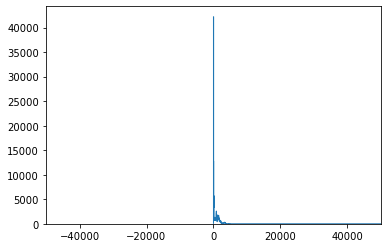

In [5]:
plt.hist(df['DEB_CRE_USD'],bins='auto', histtype='step')
plt.xlim(-50000,50000)

<AxesSubplot:>

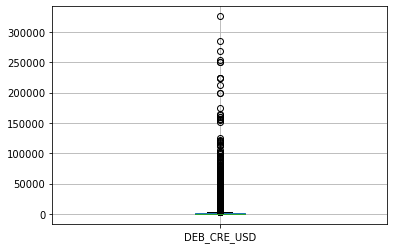

In [6]:
df.boxplot(column=['DEB_CRE_USD'])

,ACCNT_GRPV,AC_DOC_TYP,Compliance Bucket,GL_ACCOUNT,HCPClass,MATL_GROUP,POST_KEY,PROFIT_CTR,V.BIC_ZTERMPAY,V.BI_ACCNT_TGRPV,V.NAME,ZTCODE
ACCNT_GRPV,1.000000,0.707142,0.474177,0.690965,0.036770,0.000000,0.000000,0.657808,0.871634,1.000000,0.997532,0.755365
AC_DOC_TYP,0.707142,1.000000,0.343688,0.845532,0.226780,0.086137,0.121958,0.729995,0.501568,0.707142,0.870388,0.999935
Compliance Bucket,0.474177,0.343688,1.000000,0.999779,0.877231,0.150327,0.212878,0.483358,0.245134,0.474177,0.826005,0.165736
GL_ACCOUNT,0.690965,0.845532,0.999779,1.000000,0.923000,0.148849,0.211837,0.432262,0.408556,0.690965,0.675704,0.642187
HCPClass,0.036770,0.226780,0.877231,0.923000,1.000000,0.034197,0.025543,0.785177,0.549522,0.036770,0.997744,0.821459
MATL_GROUP,0.000000,0.086137,0.150327,0.148849,0.034197,1.000000,0.999996,0.714427,0.012054,0.000000,0.863421,0.085035
POST_KEY,0.000000,0.121958,0.212878,0.211837,0.025543,0.999996,1.000000,0.714421,0.020927,0.000000,0.863416,0.121113
PROFIT_CTR,0.657808,0.729995,0.483358,0.432262,0.785177,0.714427,0.714421,1.000000,0.432036,0.657808,0.467135,0.627587
V.BIC_ZTERMPAY,0.871634,0.501568,0.245134,0.408556,0.549522,0.012054,0.020927,0.432036,1.000000,0.871634,0.843922,0.532068
V.BI_ACCNT_TGRPV,1.000000,0.707142,0.474177,0.690965,0.036770,0.000000,0.000000,0.657808,0.871634,1.000000,0.997532,0.755365


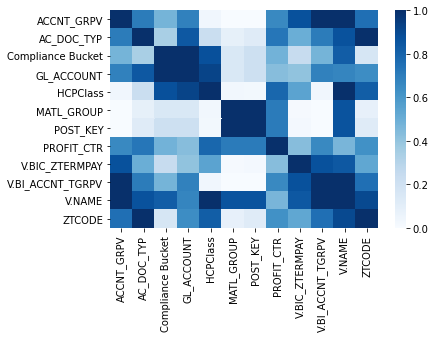

In [21]:
corMatrix = GenerateCramersVMatrix(df, ["HCPClass","PROFIT_CTR","AC_DOC_TYP","POST_KEY","GL_ACCOUNT","ZTCODE", "MATL_GROUP", "ACCNT_GRPV", "Compliance Bucket","V.BI_ACCNT_TGRPV", "V.BIC_ZTERMPAY", "V.NAME"])


sns.heatmap(corMatrix, cmap="Blues")
corMatrix

In [8]:
#Output features excludes non-features engineered fields and adds the dfscaled property to the object
modelVals.outputFeatures()

#fit_transform method minmaxscales the dfscaled dataset
modelVals.fit_transform()
dftrain = modelVals.dfscaled


dftrain.to_csv(pathBase + "\Datasets\csvoutput.csv")


dftrain

,ACCNT_GRPV_Z001,ACCNT_GRPV_Z003,ACCNT_GRPV_Z010,AC_DOC_TYP_AB,AC_DOC_TYP_CT,AC_DOC_TYP_KR,AC_DOC_TYP_RE,AC_DOC_TYP_ZP,"Compliance Bucket_Brand Reminders, Items of Medical Utility, & Cultural Courtesies",Compliance Bucket_Charitable Contributions,...,ZTCODE_FB08,ZTCODE_FB1K,ZTCODE_FB60,ZTCODE_FBD5,ZTCODE_FBVB,ZTCODE_MIRO,distanceFromMean,invoiceval,vendorCount,vendorMean
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000132,0.000303,0.009302,0.000230
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000701,0.000696,0.015992,0.000147
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000139,0.000012,0.015992,0.000147
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000127,0.000047,0.038194,0.000177
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000163,0.000018,0.038194,0.000177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115383,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000566,0.005851,0.007943,0.006340
115384,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000
115385,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000025,0.000055,1.000000,0.000088
115386,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000025,0.000055,1.000000,0.000088


In [9]:
featureList = list(dftrain[dftrain.columns.drop(list(dftrain.filter(regex='KeepAllFields')))].columns) #Filters fields NOT equal to given 

#HCPWord
modelsAnalyzer = Supervised_Analyzer(dftrain)


modelsAnalyzer = Supervised_Analyzer(dftrain)

modelObject = modelsAnalyzer.set_features(features=featureList).set_traintestsplit(target_field="HCPClass_labeled",test_split_size=.2)
#Once set_traintestsplit is called can now access arrays such as modelObject.x_train, x_test etc

#instance of gridsearch model is returned from models dict https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

SVM = modelObject.FitSVM()
#KN = modelObject.FitKNeighbors()


#to predict


Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [10]:
#SVM.Models['KNeighbors']['GSCV'].cv_results_]

#[SVM.Models['SVM']['GSCV'].best_score_,SVM.Models['KNeighbors']['GSCV'].best_score_]

SVM.Models['SVM']['GSCV'].cv_results_

{'mean_fit_time': array([5.92148447]),
 'std_fit_time': array([0.16671487]),
 'mean_score_time': array([0.19475818]),
 'std_score_time': array([0.02400756]),
 'param_C': masked_array(data=[1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['linear'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1, 'kernel': 'linear'}],
 'split0_test_score': array([0.99994583]),
 'split1_test_score': array([0.99994583]),
 'split2_test_score': array([0.99994583]),
 'split3_test_score': array([0.9998375]),
 'split4_test_score': array([0.99978334]),
 'mean_test_score': array([0.99989167]),
 'std_test_score': array([6.85143031e-05]),
 'rank_test_score': array([1])}

In [12]:
predictions = SVM.Models['SVM']['GSCV'].predict(modelObject.x_test)

testIndices = modelObject.indices_test

predictDF = pd.DataFrame({"index":testIndices, "predictedHCPClassification":predictions}).set_index("index")

predictDF = predictDF.merge(df,how='left', left_index=True, right_index=True)

predictDF.loc[predictDF.predictedHCPClassification == 1, "PredictedLabel"] = "Non-HCP"
predictDF.loc[predictDF.predictedHCPClassification == 0, "PredictedLabel"] = "HCP"

predictDF.loc[predictDF.predictedHCPClassification == predictDF.HCPClass, "PredictAccuracyBinary"] = True
predictDF.loc[predictDF.predictedHCPClassification != predictDF.HCPClass, "PredictAccuracyBinary"] = False


predictDF.to_csv(pathBase + "\Datasets\predictedoutput.csv")
#modelObject.x_train.shape


In [15]:
predictDF[['AC_DOC_NR','V.NAME', 'GL_ACCOUNT', 'AC_DOC_TYP','DEB_CRE_USD','PredictedLabel', 'HCPClass']]

,AC_DOC_NR,V.NAME,GL_ACCOUNT,AC_DOC_TYP,DEB_CRE_USD,PredictedLabel,HCPClass
index,,,,,,,
79885,1900108484,SCHNEIDER TRANSPORTATION MANAGEMENT,64900101,KR,2867.930000,Non-HCP,Non-HCP
63161,1900011024,DHL EXPRESS GERMANY GMBH,64900101,KR,24.484222,Non-HCP,Non-HCP
70955,1900000810,SCHNEIDER TRANSPORTATION MANAGEMENT,64900101,KR,3726.530000,Non-HCP,Non-HCP
48210,1900081275,AAA COOPER TRANSPORTATION,64900101,KR,683.130000,Non-HCP,Non-HCP
52353,1900172270,NAPA TRANSPORTATION INC,64900101,KR,855.050000,Non-HCP,Non-HCP
...,...,...,...,...,...,...,...
30499,1900150488,KLLM TRANSPORT,64900101,KR,1134.230000,Non-HCP,Non-HCP
87803,1900003467,DHL EXPRESS GERMANY GMBH,64900101,KR,18.845143,Non-HCP,Non-HCP
7880,1900033560,DR ANDREAS SCHNITZLER,61000115,KR,770.700000,HCP,HCP
